In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('enron_spam_data.csv')
display(df)

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,1999-12-14
6,6,meter 1517 - jan 1999,"george ,\ni need the following done :\njan 13\...",ham,1999-12-14
7,7,duns number changes,fyi\n- - - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
8,8,king ranch,there are two fields of gas that i am having d...,ham,1999-12-14
9,9,re : entex transistion,thanks so much for the memo . i would like to ...,ham,1999-12-14


In [2]:
import re

def regexClean(message_content):
    # convert everything to string
    # getting a "passing a float" error otherwise
    message_content = str(message_content) 
    
    # remove all URLs
    message_content = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', ' ', str(message_content)) 

    # remove all emails
    message_content = re.sub(r'[A-Za-z0-9._\\-]+@[A-Za-z0-9-]*\\.[a-z]{2,3}','',str(message_content))

    # remove all tags
    # https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
    message_content = re.sub(r'<[^<]+?>', '', str(message_content)) 

    # remove newline
    message_content = message_content.replace('\n', ' ')

    # convert all chars to lowercase
    message_content = message_content.lower()
    return message_content

# make a copy of the df 
df_with_punct_numb_removed = df.copy();

df['Cleaned_Message'] = df['Message'].apply(regexClean)

print(df[['Message', 'Cleaned_Message']].head())
df_with_punct_numb_removed.head()

                                             Message  \
0                                                NaN   
1  gary , production from the high island larger ...   
2             - calpine daily gas nomination 1 . doc   
3  fyi - see note below - already done .\nstella\...   
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...   

                                     Cleaned_Message  
0                                                nan  
1  gary , production from the high island larger ...  
2             - calpine daily gas nomination 1 . doc  
3  fyi - see note below - already done . stella -...  
4  fyi . - - - - - - - - - - - - - - - - - - - - ...  


,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [3]:
from string import punctuation

def punct_removal(message_content):
    message_content = str(message_content)
    
    # https://regexr.com/
    
    # remove digits
    message_content = re.sub(r'\d+', ' ', message_content)

    # remove all non-alphabetic characters
    message_content = message_content.replace(r'[^a-zA-Z]', '') 

    #remove punctuation
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    message_content = message_content.translate(str.maketrans('', '', punctuation))
    
    return message_content

df_with_punct_numb_removed['Cleaned_Message'] = df_with_punct_numb_removed['Message'].apply(punct_removal)

display(df_with_punct_numb_removed)

,Message ID,Subject,Message,Spam/Ham,Date,Cleaned_Message
0,0,christmas tree farm pictures,NaN,ham,1999-12-10,nan
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13,gary production from the high island larger b...
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14,calpine daily gas nomination doc
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14,fyi see note below already done \nstella\n ...
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14,fyi \n forwarded by lauri...
5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,1999-12-14,jackie \nsince the inlet to river plant is s...
6,6,meter 1517 - jan 1999,"george ,\ni need the following done :\njan 13\...",ham,1999-12-14,george \ni need the following done \njan \nze...
7,7,duns number changes,fyi\n- - - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14,fyi\n forwarded by gary l...
8,8,king ranch,there are two fields of gas that i am having d...,ham,1999-12-14,there are two fields of gas that i am having d...
9,9,re : entex transistion,thanks so much for the memo . i would like to ...,ham,1999-12-14,thanks so much for the memo i would like to r...


In [4]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['Cleaned_Message']).toarray()

# Convert the vectorized data to a DataFrame for better visualization
vectorized_df = pd.DataFrame(X, columns=vectorizer.get_feature_names())

# Display the first few rows of the vectorized data
print(vectorized_df.head())

         00       000  0000        01        02   03   04   05        06   07  \
0  0.000000  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0   
1  0.037818  0.351393   0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0   
2  0.000000  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0   
3  0.000000  0.000000   0.0  0.036193  0.000000  0.0  0.0  0.0  0.044361  0.0   
4  0.000000  0.000000   0.0  0.080619  0.042999  0.0  0.0  0.0  0.000000  0.0   

   ...    yo  york       you  young  your  yours  yourself  zero  zimin  zone  
0  ...   0.0   0.0  0.000000    0.0   0.0    0.0       0.0   0.0    0.0   0.0  
1  ...   0.0   0.0  0.008924    0.0   0.0    0.0       0.0   0.0    0.0   0.0  
2  ...   0.0   0.0  0.000000    0.0   0.0    0.0       0.0   0.0    0.0   0.0  
3  ...   0.0   0.0  0.032173    0.0   0.0    0.0       0.0   0.0    0.0   0.0  
4  ...   0.0   0.0  0.000000    0.0   0.0    0.0       0.0   0.0    0.0   0.0  

[5 rows x 3000 columns]


In [6]:
# Define the target variable
y = df['Spam/Ham'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# start time in seconds
start_sec = time.time()

# Train the Support Vector Machine classifier with a Radial Basis Function (RBF) kernel
# Use the default regularization parameter (C) value of 1.0
model = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', C=1.0, probability=True))
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# end time in seconds
end_sec = time.time()

# print elapsed time
elapsed_time = end_sec - start_sec
print("Elapsed time with C value of " + str(1.0) + ": " + str(elapsed_time / 60) + "min")

Elapsed time with C value of 1.0: 179.03080303668975min


In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.983540925266904
             precision    recall  f1-score   support

        ham       0.99      0.98      0.98      3276
       spam       0.98      0.99      0.98      3468

avg / total       0.98      0.98      0.98      6744



In [14]:
# start time in seconds
start_sec = time.time()

# Train the Support Vector Machine classifier with a Radial Basis Function (RBF) kernel
# Use a regularization parameter value of 0.75
model = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', C=0.75, probability=True))
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# end time in seconds
end_sec = time.time()

# print elapsed time
elapsed_time = end_sec - start_sec
print("Elapsed time with C value of " + str(0.75) + ": " + str(elapsed_time / 60) + "min")

Elapsed time with C value of 0.75: 154.63655349810918min


In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.983244365361803
             precision    recall  f1-score   support

        ham       0.99      0.98      0.98      3276
       spam       0.98      0.99      0.98      3468

avg / total       0.98      0.98      0.98      6744



In [7]:
# start time in seconds
start_sec = time.time()

# Train the Support Vector Machine classifier with a Radial Basis Function (RBF) kernel
# Use a regularization parameter value of 1.25
model = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', C=1.25, probability=True))
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# end time in seconds
end_sec = time.time()

# print elapsed time
elapsed_time = end_sec - start_sec
print("Elapsed time with C value of " + str(1.25) + ": " + str(elapsed_time / 60) + "min")

Elapsed time with C value of 1.25: 182.48709771633148min


In [8]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.984282325029656
             precision    recall  f1-score   support

        ham       0.99      0.98      0.98      3276
       spam       0.98      0.99      0.98      3468

avg / total       0.98      0.98      0.98      6744



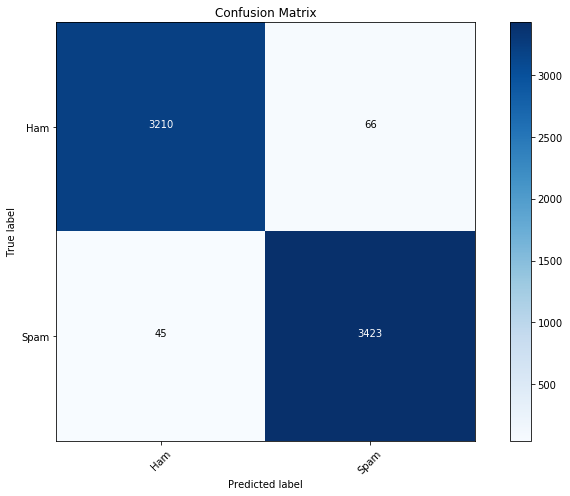

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Ham', 'Spam'], rotation=45)
plt.yticks(tick_marks, ['Ham', 'Spam'])

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

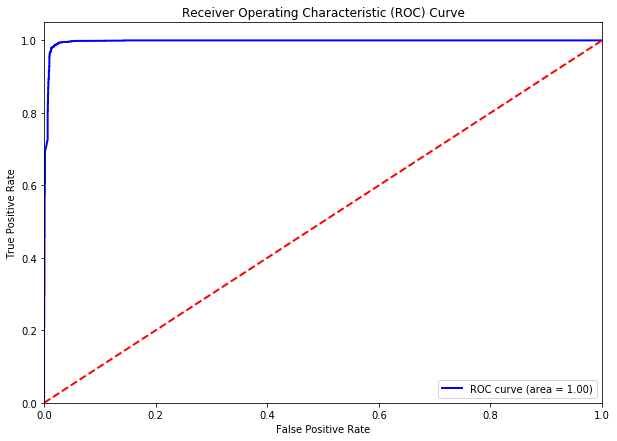

In [13]:
# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='spam')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [9]:
import numpy as np
from sklearn.inspection import permutation_importance

features_names = vectorizer.get_feature_names()

perm_importance = permutation_importance(svc, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

ModuleNotFoundError: No module named 'sklearn.inspection'